#Energy Convolutional Variational Autoencoder : EVAE#

#Energy VAE#
This is a modification of the Tensorflow CVAE tutorial (as of January 2025 https://www.tensorflow.org/tutorials/generative/cvae) inititally licensed under Apache 2.0 license available at
https://www.apache.org/licenses/LICENSE-2.0

This modification uses the "energy" distance to be used in the VAE, cf the  implementation of the Radon-Sobolev Variational Auto-Encoder as described in arXiv:1911.13135
Published version: Neural Networks Volume 141, September 2021, Pages 294-305

With slight modifications this can accomodate more general, Radon-Sobolev or Huber type distances, cf. references.

(c) Gabriel Turinici 2025


## Setup

In [149]:
# to generate gifs
!pip install imageio

In [150]:
from IPython import display

import glob
#import imageio
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import time
from tqdm import tqdm

## Load the MNIST dataset and preprocess


In [151]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

In [152]:
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  #enable this to binarize image
  #return np.where(images > .5, 1.0, 0.0).astype('float32')
  return images.astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [153]:
train_size = 60000
batch_size = 128
test_size = 10000

## Use *tf.data* to batch and shuffle the data

In [154]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

## Define the encoder and decoder networks with *tf.keras.Sequential*

We follow the intial Tensorflow tutorial and use two small ConvNets for the encoder and decoder networks. Encoder transforms initial image into a vector $z$ in the latent space. Decoder transforms this back to an image.


In [155]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self,nb_samples=100):
    """ samples from the latent space target distribution which is a gaussian"""
    latent_vectors=tf.random.normal(shape=(nb_samples, self.latent_dim))
    return self.decode(latent_vectors, apply_sigmoid=True)

  def encode(self, x):
    return self.encoder(x)

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

#Define the energy distance to a Gaussian#

In [156]:
import tensorflow as tf

@tf.function
def euclidean_norm_squared(X, axis=None):
  return tf.reduce_sum(tf.square(X), axis=axis)

# the 'energy' distance to a Gaussian
@tf.function
def energy_distance_to_gaussian(Z):
    """
    Computes the energy distance to a multi-dimensional Gaussian. See the reference for
    the formulas.
    Input Z tensor of shape (batch_size=Nf,latent_dim=Df)
    """

    Nf = tf.stop_gradient(tf.cast(tf.shape(Z)[0], tf.float32)) # batch size as float
    Df = tf.stop_gradient(tf.cast(tf.shape(Z)[1], tf.float32)) # dimension as float

    f0 = tf.stop_gradient(
            (tf.sqrt(2.) - 1.) * tf.exp(tf.math.lgamma(Df / 2.0 + 0.5)
            - tf.math.lgamma(Df / 2.0))
            )
    ddf0 = tf.stop_gradient(
    tf.exp(tf.math.lgamma(0.5 + Df / 2.) - tf.math.lgamma(1. + Df / 2.)) / tf.sqrt(2.))
    c0 = f0 - 1. / ddf0 # first constant in function
    c1 = 1 / (ddf0**2) # second constant

    dist_real_Z = euclidean_norm_squared(Z, axis=1)
    distZZ = euclidean_norm_squared(tf.subtract(tf.expand_dims(Z, 0), tf.expand_dims(Z, 1)), axis=2)

    # set diag = 1 because of the singularity of sqrt'(x) in zero. This is a numerical
    # issue due to low precision of the GPU computations; it is compensated
    # exactly in the return value
    distZZ = tf.linalg.set_diag(distZZ, tf.ones([tf.stop_gradient(tf.shape(Z)[0])]), name=None)
    # remark: this is similar to a pseudo-Huber function

    smalleps = 1e-4
    return c0 + tf.reduce_mean(tf.sqrt(dist_real_Z + c1)) \
      - 0.5 * tf.reduce_mean(tf.sqrt(distZZ + 1e-6)) + 0.5 / Nf + 2. * tf.sqrt(smalleps)


## Define the loss function and the optimizer

VAEs train by minimizing the mean L2 reconstruction loss plus a the energy distance between the distribution of latent vectors and the normal distribution;
in practice, optimize the expectation of :

$$ \|Decoder(Encoder(x))-x \|^2_{L^2} + dist(\text{latent distrib}, \text{target distrib})^2$$.



In [157]:
optimizer = tf.keras.optimizers.Adam(1e-4)

@tf.function
def compute_loss(model, x,coefficient=1.0):
  latent_vectors = model.encode(x)
  xrec= model.decode(latent_vectors)
  reconstruction_error= tf.reduce_mean(tf.square(x-xrec))
  distance= energy_distance_to_gaussian(latent_vectors)
  return reconstruction_error+ distance,reconstruction_error,distance


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss,rec_err,dist = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss,rec_err,dist

## Training

* Start by iterating over the dataset
* During each iteration, pass the image to the encoder, decoder to obtain the reconstructed images and the latent vectors;
* construct the loss

### Generating images

* After training generate some images: generate latent vectors from the target distribution (multivariate normal) and then pass them through the decoder.

In [158]:
epochs = 40
# set the dimension of the latent space =2 for visualization
latent_dim = 4
num_examples_to_generate = 16

# keep the random vector constant for generation to see the evolution
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [159]:
def reconstruct_images(model, epoch, test_sample):
  """ generates images from test samples, saves in jpg file
  We plot initial images then reconstructed image"""
  z = model.encode(test_sample)
  predictions = model.decode(z).numpy()
  fig = plt.figure(figsize=(0.75*8,0.75*4))
  for i in range(predictions.shape[0]):
    plt.subplot(4, 8, 2*i + 1)
    plt.imshow(test_sample[i, :, :, 0], cmap='gray')
    plt.axis('off')
    plt.subplot(4, 8, 2*i + 2)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  plt.tight_layout()# minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()
  return z,predictions

def generate_and_plot(model, z=random_vector_for_generation,label=""):
  """ generates images from the latent z, saves in jpg file"""
  predictions = model.decode(z).numpy()
  fig = plt.figure(figsize=(8*0.75,2*0.75))
  for i in range(predictions.shape[0]):
    plt.subplot(2, 8, i +1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')
  plt.tight_layout()# minimizes the overlap between 2 sub-plots
  plt.savefig('generated'+label+'.jpg')
  plt.show()
  return None

def generate_latent_representation(model, epoch, test_sample):
  """ This function generate a latent space representation of a test sample
  and plots it if the dimension is 2"""
  z = model.encode(test_sample)
  if(z.shape[-1]==2):
    fig = plt.figure(figsize=(4, 4))
    plt.scatter(z[:,0],z[:,1],s=0.5)
    plt.tight_layout()# minimizes the overlap between 2 sub-plots
    plt.savefig('latent_at_epoch_{:04d}.png'.format(epoch))
    plt.show()
  return z

In [160]:
# Pick a sample of the test set for generating output images
#assert batch_size >= num_examples_to_generate
#for test_batch in test_dataset.take(1):
#  test_sample = test_batch[0:num_examples_to_generate, :, :, :]
test_sample=test_images[np.random.choice(test_images.shape[0],num_examples_to_generate),:,:,:]
num_latent_points=500
test_sample_for_latent=test_images[np.random.choice(test_images.shape[0],num_latent_points),:,:,:]

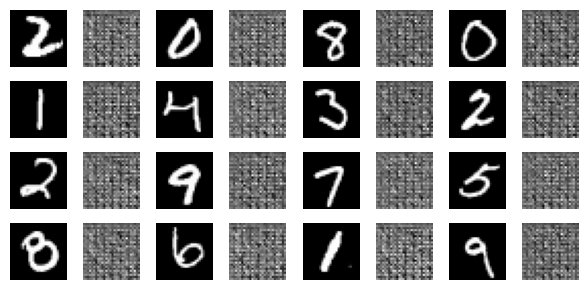

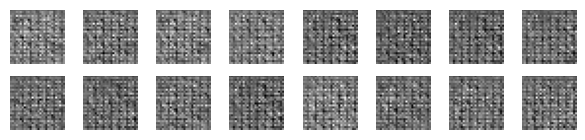

In [161]:
_=reconstruct_images(model, 0, test_sample)
generate_and_plot(model)

Epoch: 1 Loss: 0.0707, rec_err: 0.0463 dist: 0.0245: 100%|██████████| 469/469 [00:20<00:00, 22.55it/s]


Epoch: 1, Test set loss: 0.0658939778804779, time elapse for current epoch: 20.80663561820984


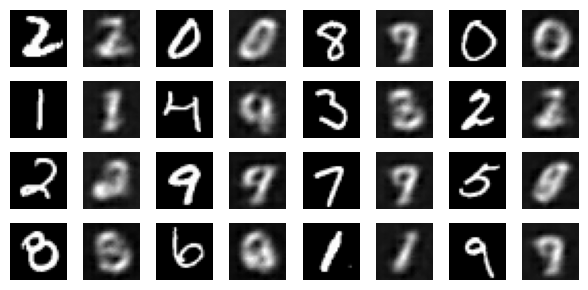

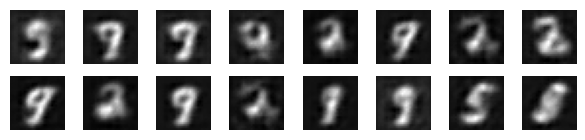

Epoch: 2 Loss: 0.0542, rec_err: 0.0451 dist: 0.0091: 100%|██████████| 469/469 [00:05<00:00, 85.82it/s]


Epoch: 2, Test set loss: 0.05707305669784546, time elapse for current epoch: 5.478697776794434


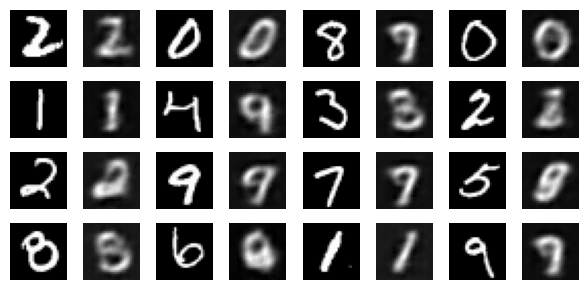

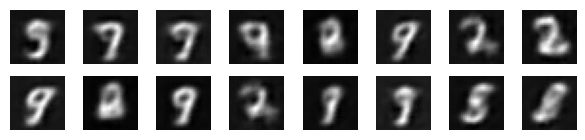

Epoch: 3 Loss: 0.0520, rec_err: 0.0410 dist: 0.0111: 100%|██████████| 469/469 [00:05<00:00, 91.89it/s]


Epoch: 3, Test set loss: 0.055595990270376205, time elapse for current epoch: 5.119617223739624


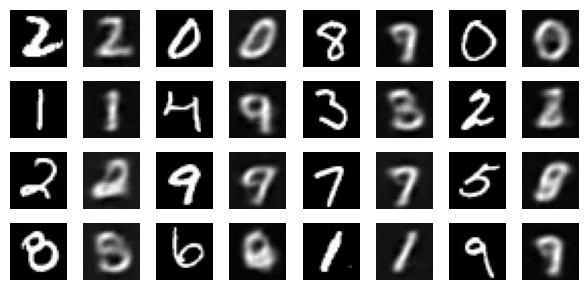

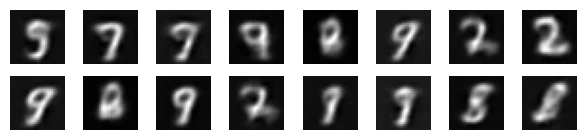

Epoch: 4 Loss: 0.0485, rec_err: 0.0408 dist: 0.0077: 100%|██████████| 469/469 [00:10<00:00, 45.86it/s]


Epoch: 4, Test set loss: 0.053691912442445755, time elapse for current epoch: 10.241634845733643


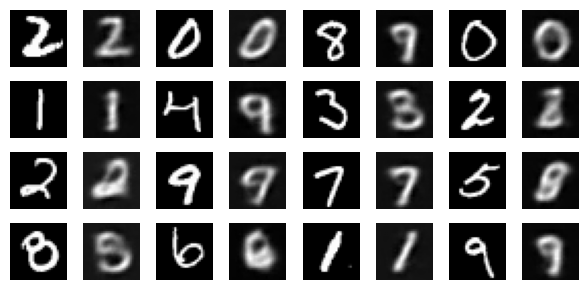

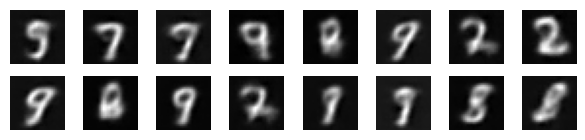

Epoch: 5 Loss: 0.0540, rec_err: 0.0401 dist: 0.0139: 100%|██████████| 469/469 [00:10<00:00, 45.87it/s]


Epoch: 5, Test set loss: 0.055596012622117996, time elapse for current epoch: 10.229859590530396


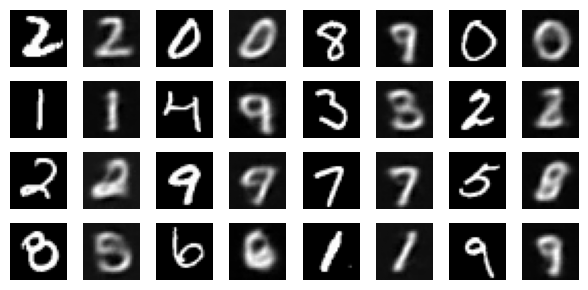

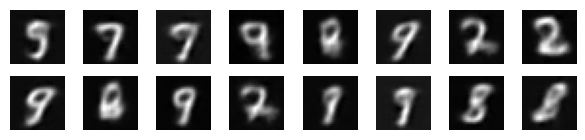

Epoch: 6 Loss: 0.0435, rec_err: 0.0369 dist: 0.0066: 100%|██████████| 469/469 [00:10<00:00, 45.86it/s]


Epoch: 6, Test set loss: 0.050481345504522324, time elapse for current epoch: 10.232643842697144


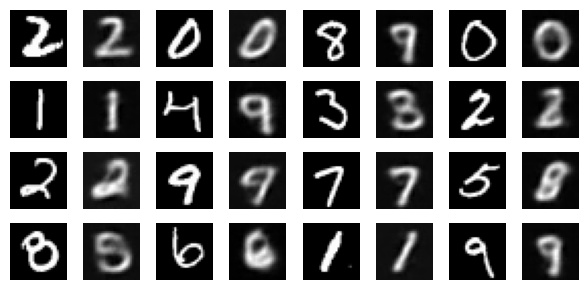

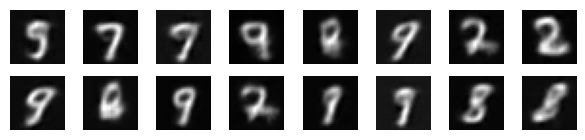

Epoch: 7 Loss: 0.0472, rec_err: 0.0393 dist: 0.0079: 100%|██████████| 469/469 [00:10<00:00, 45.86it/s]


Epoch: 7, Test set loss: 0.051435574889183044, time elapse for current epoch: 10.238221645355225


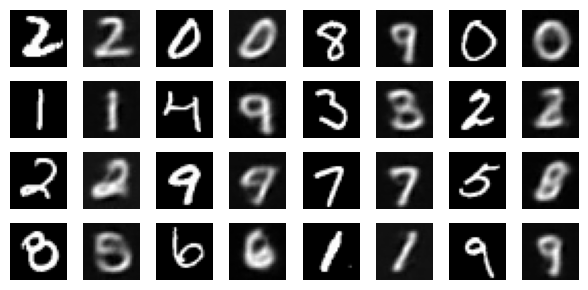

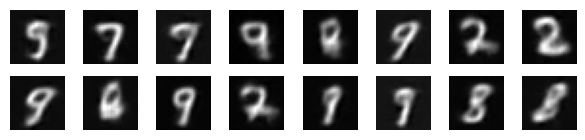

Epoch: 8 Loss: 0.0475, rec_err: 0.0406 dist: 0.0069: 100%|██████████| 469/469 [00:05<00:00, 88.05it/s]


Epoch: 8, Test set loss: 0.050396207720041275, time elapse for current epoch: 5.332224130630493


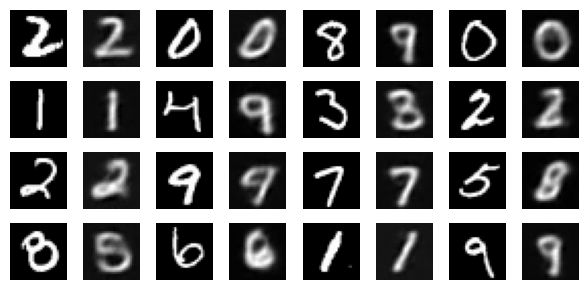

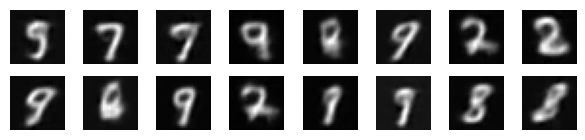

Epoch: 9 Loss: 0.0697, rec_err: 0.0380 dist: 0.0317: 100%|██████████| 469/469 [00:10<00:00, 45.85it/s]


Epoch: 9, Test set loss: 0.048589229583740234, time elapse for current epoch: 10.238733291625977


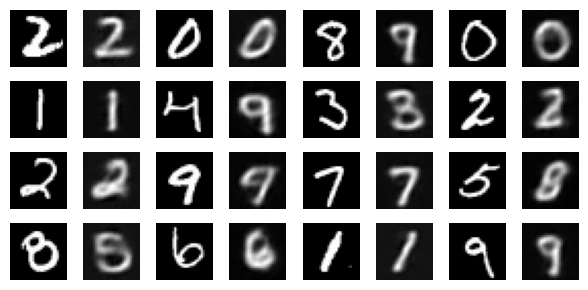

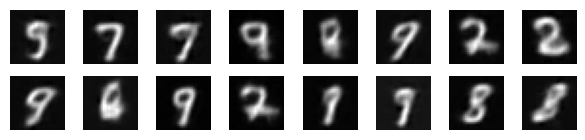

Epoch: 10 Loss: 0.0474, rec_err: 0.0401 dist: 0.0073: 100%|██████████| 469/469 [00:05<00:00, 87.22it/s]


Epoch: 10, Test set loss: 0.05124378949403763, time elapse for current epoch: 5.39452052116394


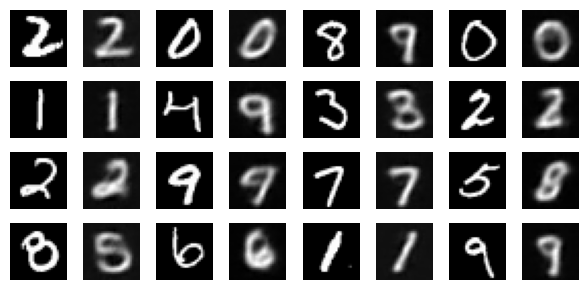

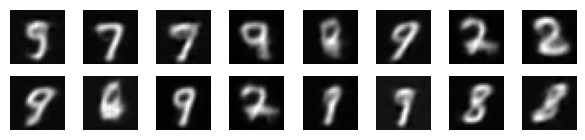

Epoch: 11 Loss: 0.0430, rec_err: 0.0384 dist: 0.0046: 100%|██████████| 469/469 [00:06<00:00, 77.60it/s]


Epoch: 11, Test set loss: 0.049987100064754486, time elapse for current epoch: 6.05037522315979


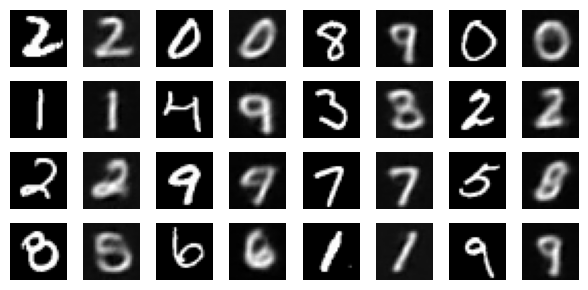

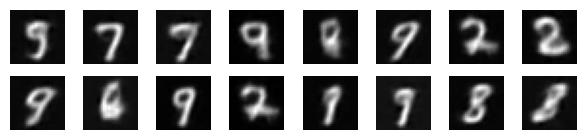

Epoch: 12 Loss: 0.0693, rec_err: 0.0347 dist: 0.0346: 100%|██████████| 469/469 [00:05<00:00, 83.14it/s]


Epoch: 12, Test set loss: 0.04791974276304245, time elapse for current epoch: 5.648662328720093


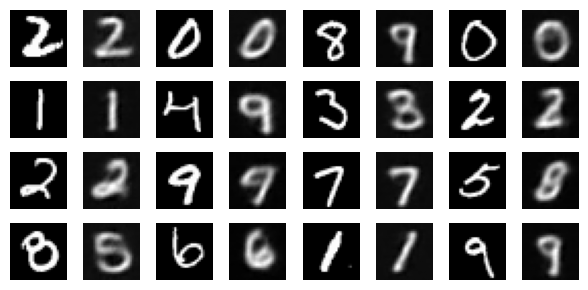

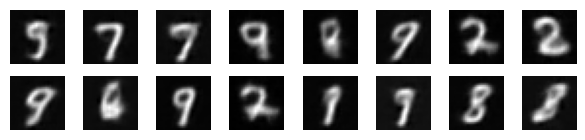

Epoch: 13 Loss: 0.0574, rec_err: 0.0366 dist: 0.0208: 100%|██████████| 469/469 [00:05<00:00, 87.61it/s]


Epoch: 13, Test set loss: 0.048943862318992615, time elapse for current epoch: 5.358472585678101


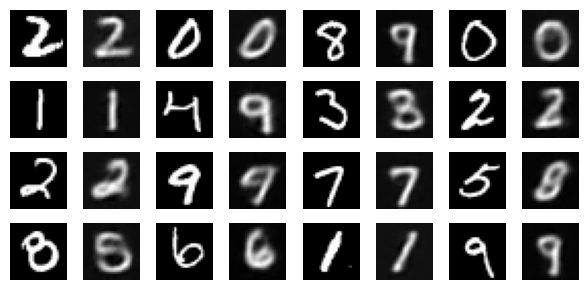

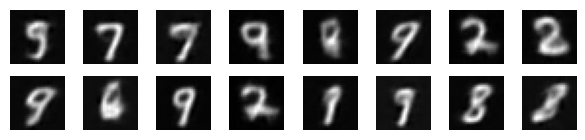

Epoch: 14 Loss: 0.0532, rec_err: 0.0407 dist: 0.0125: 100%|██████████| 469/469 [00:05<00:00, 82.70it/s]


Epoch: 14, Test set loss: 0.048900216817855835, time elapse for current epoch: 5.680153846740723


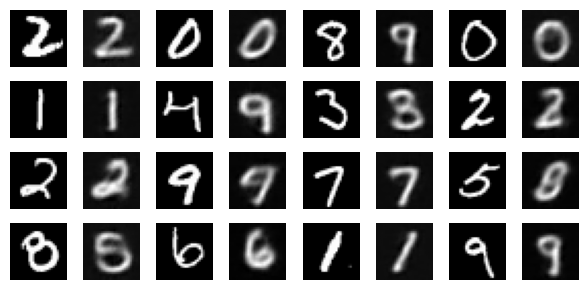

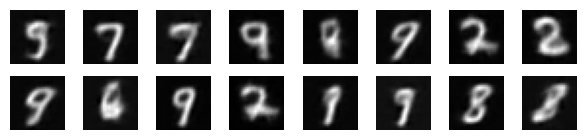

Epoch: 15 Loss: 0.0422, rec_err: 0.0350 dist: 0.0072: 100%|██████████| 469/469 [00:05<00:00, 87.42it/s]


Epoch: 15, Test set loss: 0.04854803532361984, time elapse for current epoch: 5.372377872467041


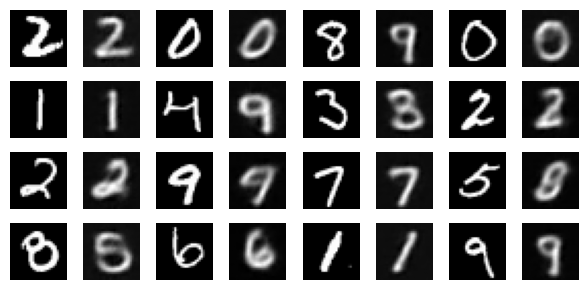

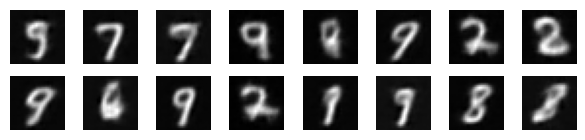

Epoch: 16 Loss: 0.0433, rec_err: 0.0358 dist: 0.0075: 100%|██████████| 469/469 [00:10<00:00, 45.86it/s]


Epoch: 16, Test set loss: 0.046774864196777344, time elapse for current epoch: 10.23667025566101


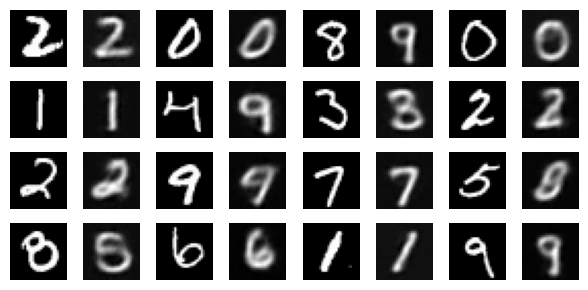

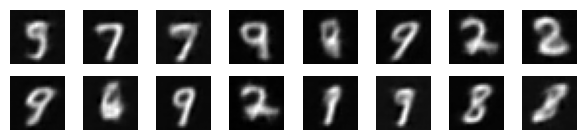

Epoch: 17 Loss: 0.0511, rec_err: 0.0369 dist: 0.0142: 100%|██████████| 469/469 [00:10<00:00, 45.86it/s]


Epoch: 17, Test set loss: 0.04640059918165207, time elapse for current epoch: 10.236940383911133


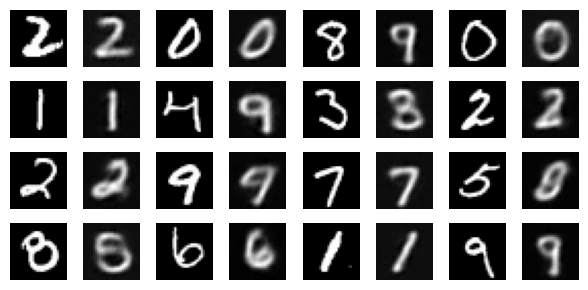

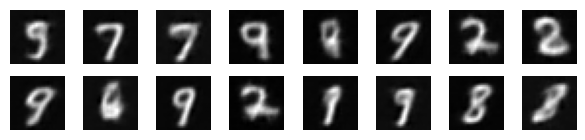

Epoch: 18 Loss: 0.0547, rec_err: 0.0361 dist: 0.0186: 100%|██████████| 469/469 [00:05<00:00, 87.63it/s]


Epoch: 18, Test set loss: 0.046849433332681656, time elapse for current epoch: 5.36043643951416


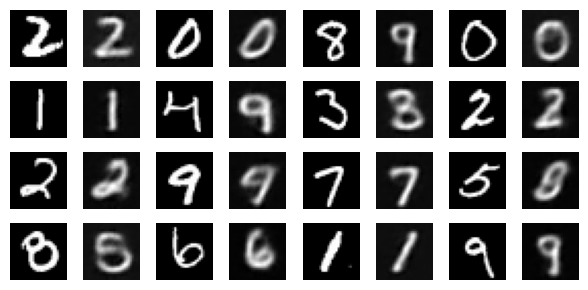

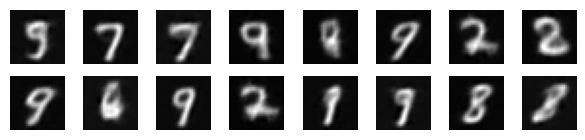

Epoch: 19 Loss: 0.0498, rec_err: 0.0366 dist: 0.0132: 100%|██████████| 469/469 [00:05<00:00, 86.69it/s]


Epoch: 19, Test set loss: 0.049732454121112823, time elapse for current epoch: 5.418756723403931


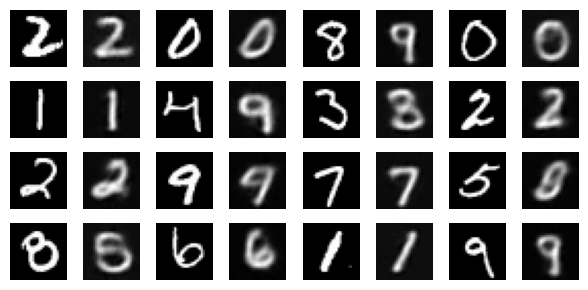

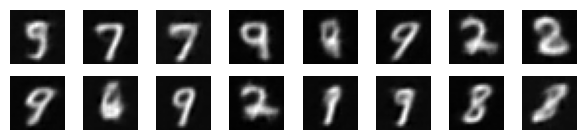

Epoch: 20 Loss: 0.0491, rec_err: 0.0354 dist: 0.0137: 100%|██████████| 469/469 [00:05<00:00, 87.65it/s]


Epoch: 20, Test set loss: 0.046330228447914124, time elapse for current epoch: 5.358923435211182


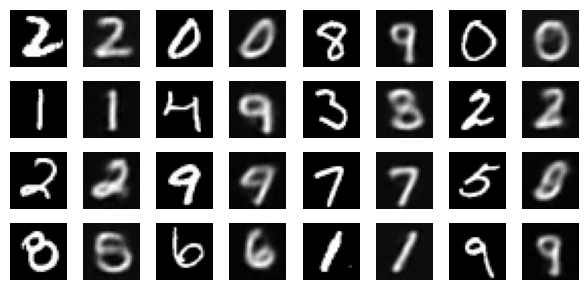

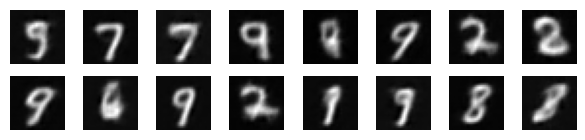

Epoch: 21 Loss: 0.0601, rec_err: 0.0315 dist: 0.0286: 100%|██████████| 469/469 [00:10<00:00, 45.85it/s]


Epoch: 21, Test set loss: 0.047352373600006104, time elapse for current epoch: 10.236939668655396


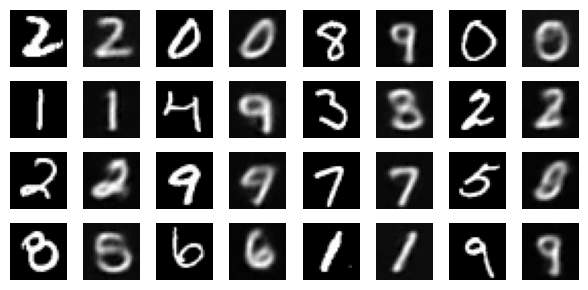

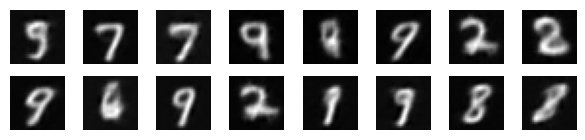

Epoch: 22 Loss: 0.0558, rec_err: 0.0358 dist: 0.0199: 100%|██████████| 469/469 [00:10<00:00, 45.85it/s]


Epoch: 22, Test set loss: 0.04767538607120514, time elapse for current epoch: 10.233964443206787


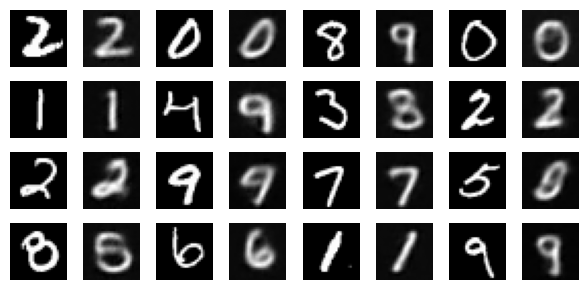

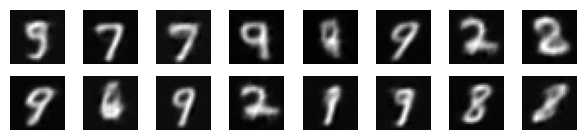

Epoch: 23 Loss: 0.0509, rec_err: 0.0374 dist: 0.0135: 100%|██████████| 469/469 [00:10<00:00, 45.87it/s]


Epoch: 23, Test set loss: 0.0471743643283844, time elapse for current epoch: 10.234003782272339


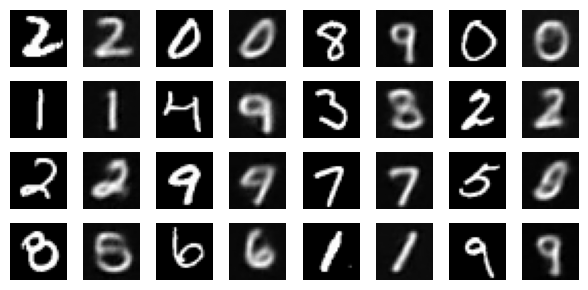

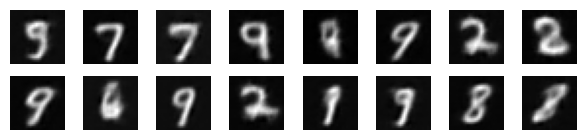

Epoch: 24 Loss: 0.0441, rec_err: 0.0336 dist: 0.0105: 100%|██████████| 469/469 [00:05<00:00, 89.01it/s]


Epoch: 24, Test set loss: 0.04474572464823723, time elapse for current epoch: 5.274037837982178


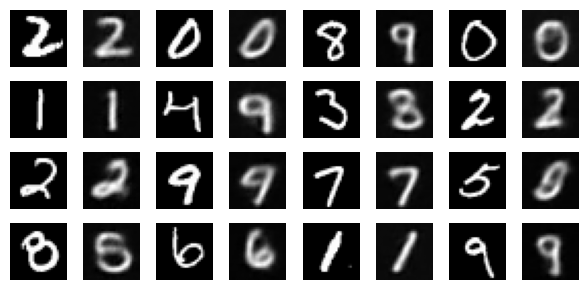

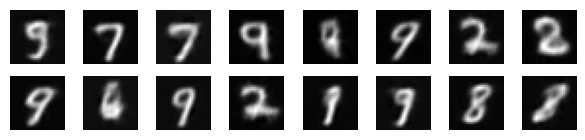

Epoch: 25 Loss: 0.0421, rec_err: 0.0355 dist: 0.0066: 100%|██████████| 469/469 [00:05<00:00, 86.25it/s]


Epoch: 25, Test set loss: 0.04664062336087227, time elapse for current epoch: 5.443372964859009


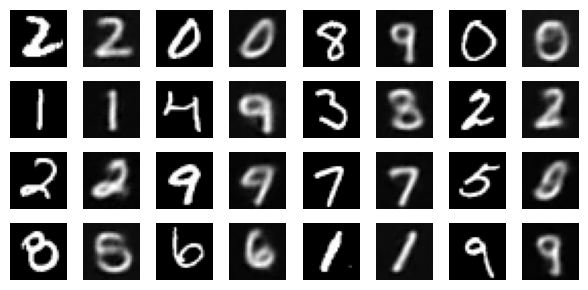

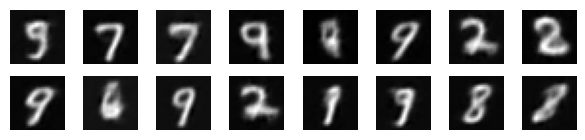

Epoch: 26 Loss: 0.0431, rec_err: 0.0357 dist: 0.0074: 100%|██████████| 469/469 [00:05<00:00, 89.06it/s]


Epoch: 26, Test set loss: 0.04399227723479271, time elapse for current epoch: 5.274420499801636


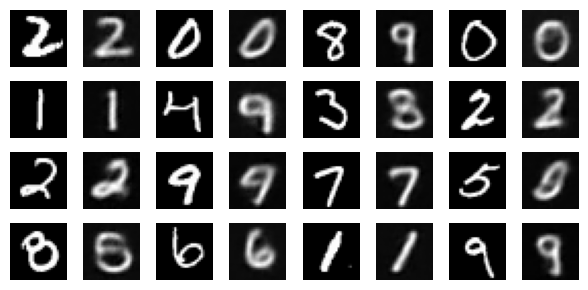

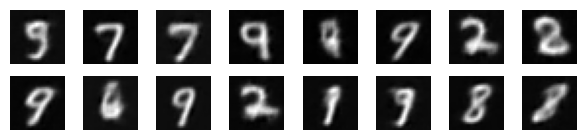

Epoch: 27 Loss: 0.0422, rec_err: 0.0350 dist: 0.0072: 100%|██████████| 469/469 [00:10<00:00, 45.84it/s]


Epoch: 27, Test set loss: 0.04898032918572426, time elapse for current epoch: 10.238174438476562


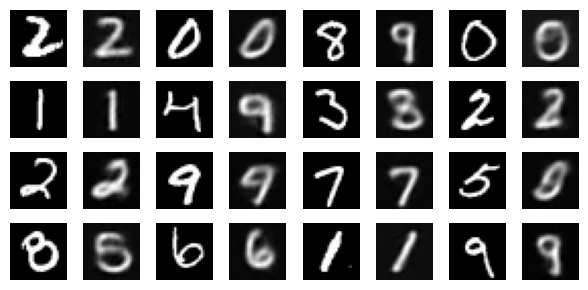

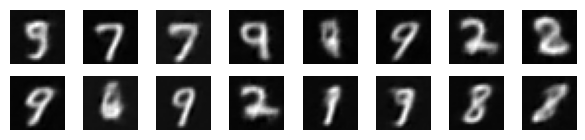

Epoch: 28 Loss: 0.0447, rec_err: 0.0351 dist: 0.0096: 100%|██████████| 469/469 [00:05<00:00, 82.35it/s]


Epoch: 28, Test set loss: 0.04713514447212219, time elapse for current epoch: 5.700960874557495


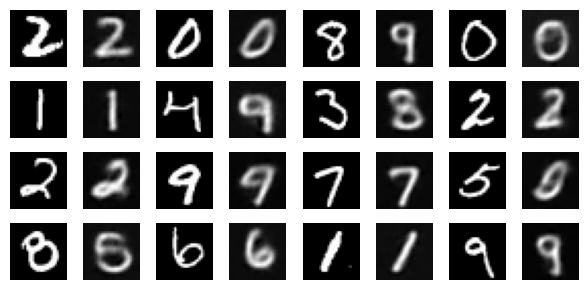

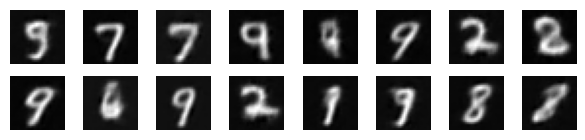

Epoch: 29 Loss: 0.0485, rec_err: 0.0355 dist: 0.0130: 100%|██████████| 469/469 [00:10<00:00, 45.84it/s]


Epoch: 29, Test set loss: 0.045219242572784424, time elapse for current epoch: 10.239347457885742


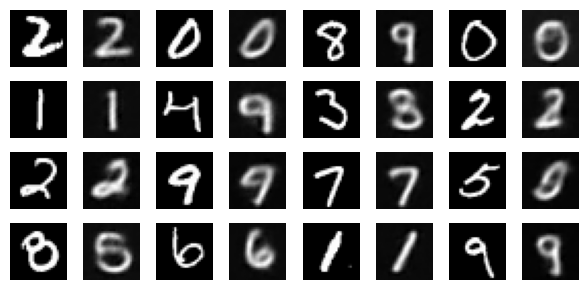

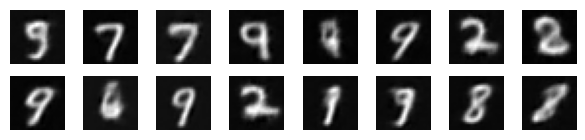

Epoch: 30 Loss: 0.0486, rec_err: 0.0364 dist: 0.0122: 100%|██████████| 469/469 [00:05<00:00, 91.16it/s]


Epoch: 30, Test set loss: 0.04489433392882347, time elapse for current epoch: 5.153359413146973


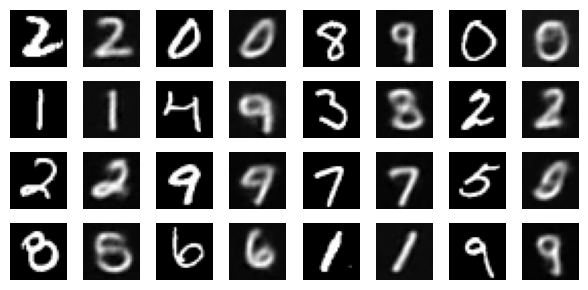

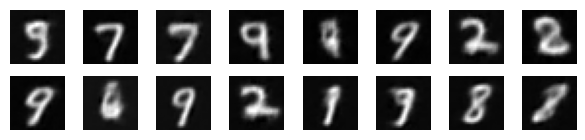

Epoch: 31 Loss: 0.0383, rec_err: 0.0329 dist: 0.0054: 100%|██████████| 469/469 [00:05<00:00, 84.50it/s]


Epoch: 31, Test set loss: 0.04562431946396828, time elapse for current epoch: 5.558745861053467


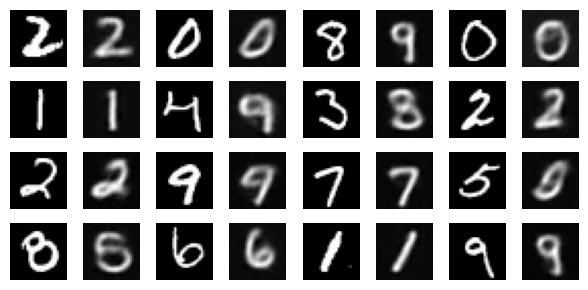

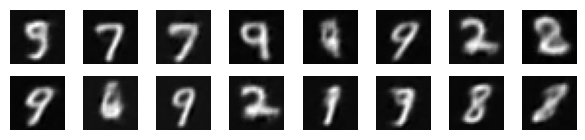

Epoch: 32 Loss: 0.0500, rec_err: 0.0369 dist: 0.0131: 100%|██████████| 469/469 [00:10<00:00, 45.86it/s]


Epoch: 32, Test set loss: 0.04544808715581894, time elapse for current epoch: 10.234094142913818


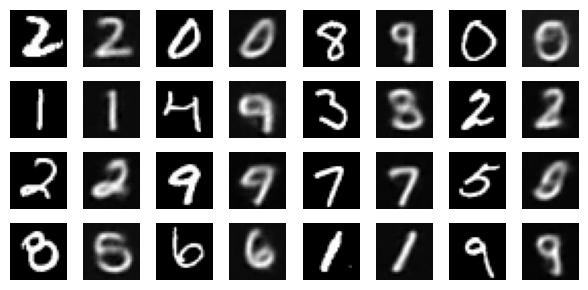

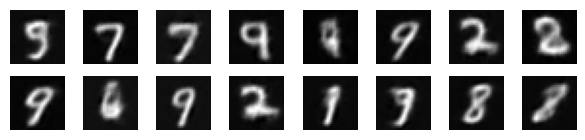

Epoch: 33 Loss: 0.0419, rec_err: 0.0361 dist: 0.0058: 100%|██████████| 469/469 [00:10<00:00, 45.86it/s]


Epoch: 33, Test set loss: 0.04635273665189743, time elapse for current epoch: 10.233445644378662


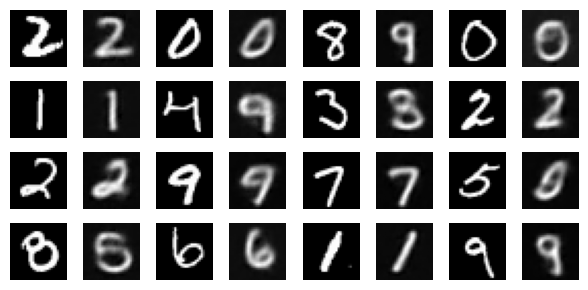

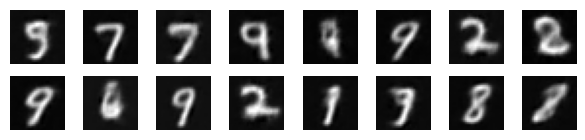

Epoch: 34 Loss: 0.0450, rec_err: 0.0347 dist: 0.0103: 100%|██████████| 469/469 [00:10<00:00, 45.85it/s]


Epoch: 34, Test set loss: 0.04476737231016159, time elapse for current epoch: 10.239712953567505


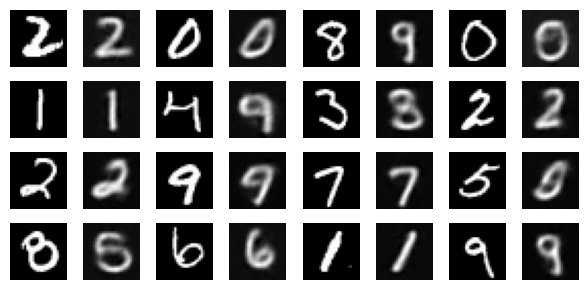

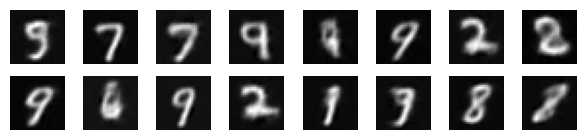

Epoch: 35 Loss: 0.0438, rec_err: 0.0355 dist: 0.0083: 100%|██████████| 469/469 [00:05<00:00, 85.31it/s]


Epoch: 35, Test set loss: 0.045067720115184784, time elapse for current epoch: 5.5067713260650635


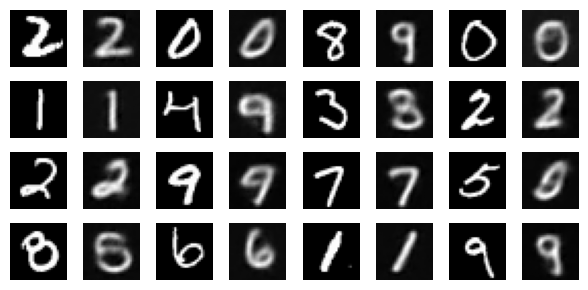

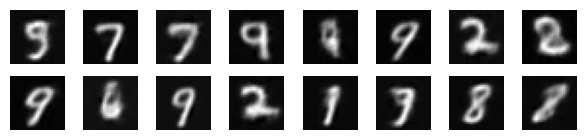

Epoch: 36 Loss: 0.0527, rec_err: 0.0360 dist: 0.0167: 100%|██████████| 469/469 [00:05<00:00, 89.52it/s]


Epoch: 36, Test set loss: 0.045054707676172256, time elapse for current epoch: 5.246294260025024


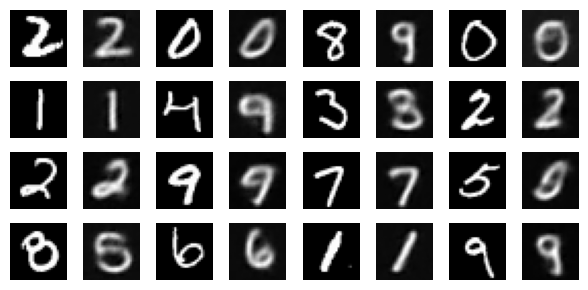

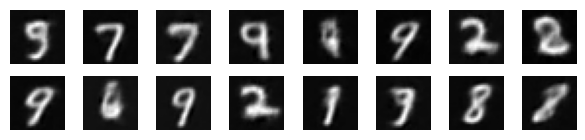

Epoch: 37 Loss: 0.0515, rec_err: 0.0309 dist: 0.0206: 100%|██████████| 469/469 [00:05<00:00, 82.60it/s]


Epoch: 37, Test set loss: 0.045269306749105453, time elapse for current epoch: 5.685847282409668


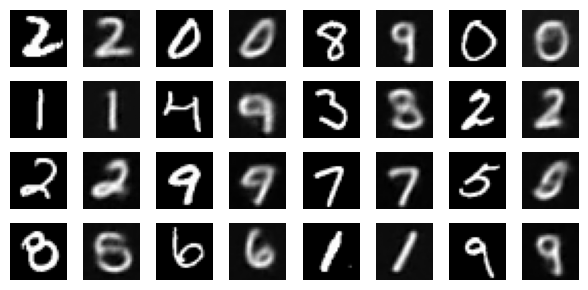

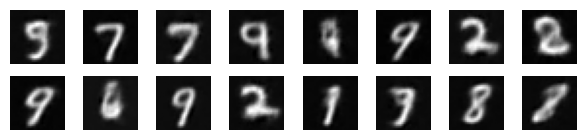

Epoch: 38 Loss: 0.0416, rec_err: 0.0350 dist: 0.0066: 100%|██████████| 469/469 [00:10<00:00, 45.87it/s]


Epoch: 38, Test set loss: 0.0437646359205246, time elapse for current epoch: 10.231042385101318


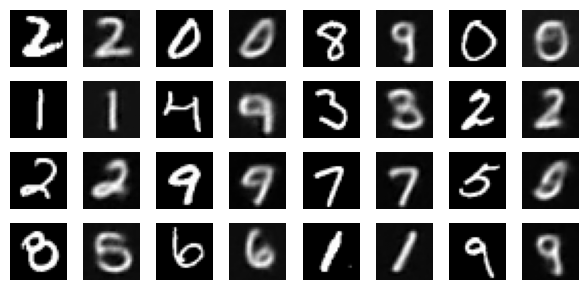

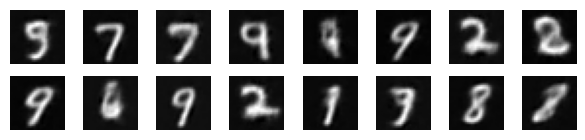

Epoch: 39 Loss: 0.0519, rec_err: 0.0387 dist: 0.0132: 100%|██████████| 469/469 [00:10<00:00, 45.86it/s]


Epoch: 39, Test set loss: 0.04435807466506958, time elapse for current epoch: 10.233242750167847


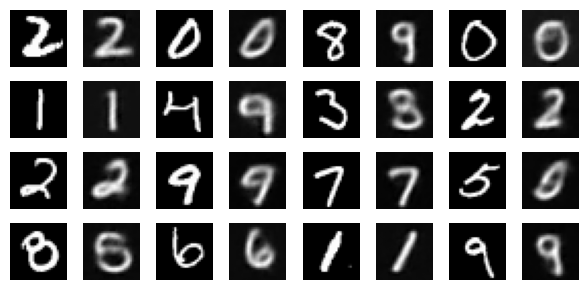

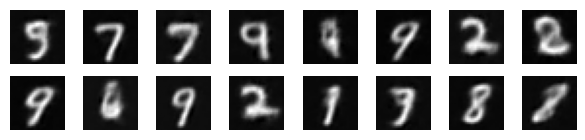

Epoch: 40 Loss: 0.0537, rec_err: 0.0356 dist: 0.0181: 100%|██████████| 469/469 [00:10<00:00, 45.84it/s]


Epoch: 40, Test set loss: 0.04477312043309212, time elapse for current epoch: 10.236871719360352


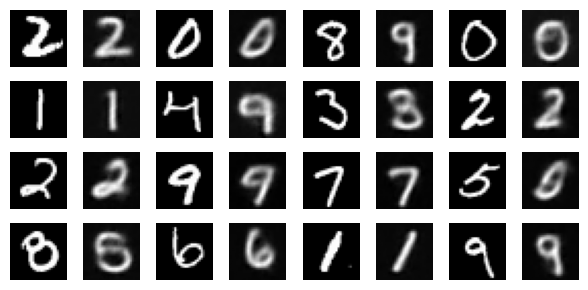

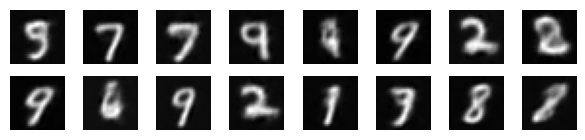

In [162]:

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in (tqdm_pbar:= tqdm(train_dataset)):
    loss,rec_err,dist=train_step(model, train_x, optimizer)
    #generate some messages containing main components of the loss function
    tqdm_pbar.set_description(f"Epoch: {epoch} Loss: {loss.numpy():.4f}, rec_err: {rec_err.numpy():.4f} dist: {dist.numpy():.4f}")
  end_time = time.time()

  loss_mean = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss,rec_err,dist=compute_loss(model, test_x)
    loss_mean(loss)
  loss_mean_value = loss_mean.result()
#  display.clear_output(wait=False)
  print('Epoch: {}, Test set loss: {}, time elapse for current epoch: {}'
        .format(epoch, loss_mean_value, end_time - start_time))
  _,_=reconstruct_images(model, epoch, test_sample)
  generate_and_plot(model,random_vector_for_generation,label=f"_iter{epoch}")
  if(model.latent_dim==2):
    _=generate_latent_representation(model, epoch, test_sample_for_latent)

### Display a generated image from the last training epoch

In [163]:
def display_image(epoch_no):
  #return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch-1))

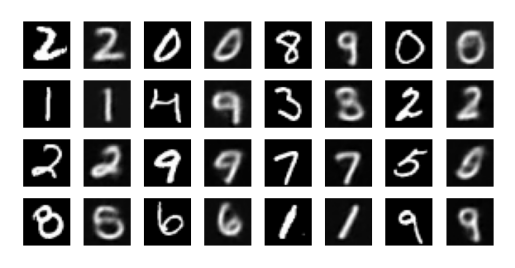

In [164]:
plt.imshow(display_image(epoch))
_=plt.axis('off')  # Display images

### Display an animated GIF of all the saved images

In [165]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

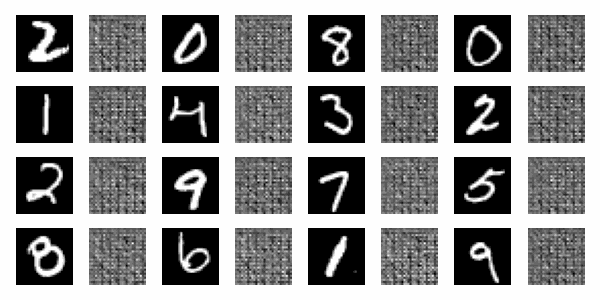

In [166]:
#import tensorflow_docs.vis.embed as embed
#embed.embed_file(anim_file)
from PIL import Image
from IPython.display import display
# Load the GIF file
gif = Image.open(anim_file)
# Display the GIF
display(gif)